# Atribución Automática de Autoría de publicaciones en foros

#### Solución de software para la asignatura de TFG del Grado en Ingeniería Informática de la UNIR

###### Autor: José Herce Preciado

In [1]:
from tfg.textmining.preprocessing import show_statistics

## PARÁMETROS CONFIGURACIÓN EXPERIMENTO

In [2]:
###############################################################################
# Manipulación de los datos
###############################################################################
origen_datos = "mongo"  # "local" o "mongo" - Si "local" se cargará el dataset desde el disco. Si "mongo" se cargará desde la base de datos.
save_preprocessed_temp = False  # Si True, se guardará el dataset preprocesado en el disco.
# Anonimización de los datos - Si True, se guardará el dataset anonimizado en la base de datos
anonymize_and_save = False  # Si False, se anonimizarán los datos pero no se guardarán en la base de datos
collection_name = "anonimizado_util"  # Nombre de la colección en la que se guardarán los datos anonimizados
collection_data = "anonymized_posts_100"  # Nombre de la colección del data set

collection = collection_data

###############################################################################
# Preprocesamiento de los datos
###############################################################################
description = "Prueba"
n_authors = 3  # 200,
min_words = 5  # 30,
max_words = None  # None,
min_doc_per_author = None  # 100,
n_doc_per_author = None  # None # 1000 # Si longest_docs=False se dará error en caso de no existir documentos suficientes para algún autor.
longest_docs = True  # True: Seleccionar los documentos más largos. False: Seleccionar los documentos aleatoriamente.
# Estadísticas y gráficas
show_stats = False
num_bars = 'auto'  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.

description = f"3 autores minimo {min_words} palabras sin documentos minimos, balanceo pasivo- LIMPIANDO y NO TOKENIZANOD - TRIGRAMAS"

###############################################################################
# Limpieza de los datos
###############################################################################
mis_tecnicas = True
stop_words=True
max_df=0.8  # Palabras muy frecuentes
min_df=1  # Palabras poco frecuentes
strip_accents=True
lowercase=True

# True: Tokenizar; False: Eliminar; None: No hacer nada
tokenize_emoticons = False
tokenize_numbers = False
tokenize_simbols = False
tokenize_punctuation = False
tokenize_urls = False


###############################################################################
# Tokenización de los datos
###############################################################################
ngram_range=(1, 3)
binarize=False
balance='all_set'  # 'all_set' 'sub_set'
balance_to_target=False
target=None  # Clase objetivo binarización
balance_passive=True

###############################################################################
# Extracción de características de los datos
###############################################################################
test_size=0.3
sublinear_tf=True # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf). Default: False.
smooth_idf=True  # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions. Default: True.
use_idf=True  # Enable inverse-document-frequency reweighting. If False, idf(t) = 1. Default: True.

# TODO No propagada al Vectorizador
norm='l2'  # Each output row will have unit norm, either: Default: 'l2'
           #    'l2': Sum of squares of vector elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.
           #    'l1': Sum of absolute values of vector elements is 1. See preprocessing.normalize.
           #    None: No normalization.


###############################################################################
# Clasificación de los datos
###############################################################################
classifiers_list = [
    'RidgeClassifier',
    'LogisticRegression',
    'BernoulliNB',
    'NearestCentroid',
    'LinearSVC',
    # 'NuSVC',
    # 'SVC',
    # 'RandomForestClassifier',
    # 'DecisionTreeClassifier',
    'ExtraTreeClassifier',
    # 'GradientBoostingClassifier',
    # 'LogisticRegressionCV',
    # 'RidgeClassifierCV',
    # 'MLPClassifier',
]


# description = "Sin limitar numero de palabras y tokenizando el texto"


In [3]:
from tfg.datos import DataBase, get_temp_dataset, set_temp_dataset, anonymize_authors, get_experiment_id
metadata = dict(_id=get_experiment_id())
metadata["description"] = description
db = DataBase(collection=collection)

## Minería de texto

### Fase de recolección de datos

In [4]:

if origen_datos == "local":
    print("Cargando datos desde el disco...")
    df_all = get_temp_dataset()
elif origen_datos == "mongo":
    print("Cargando datos desde la base de datos...")
    df_all = db.get_dataframe(collection=collection)
    set_temp_dataset(df_all)
else:
    raise ValueError("El parámetro origen_datos debe ser 'local' o 'mongo'")
df_all.info()

Cargando datos desde la base de datos...
Recuperados 905129 documentos de la colección anonymized_posts_100
Guardar fichero: ./tmp/temp_dataset.pkl
Objeto guardado en el archivo temp_dataset.pkl
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905129 entries, 0 to 905128
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   _id     905129 non-null  object
 1   text    905129 non-null  object
 2   author  905129 non-null  object
dtypes: object(3)
memory usage: 20.7+ MB


In [5]:
df_all.count()

_id       905129
text      905129
author    905129
dtype: int64

### Fase de preprocesamiento

In [6]:

from tfg.textmining.preprocessing import eliminar_columnas

df_all = eliminar_columnas(df_all, ["_id", "fecha", "numeroEntrada", "cita", "url", "tipoUsuario", "thread"])
df_all.info()

Eliminando columnas:  ['_id']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905129 entries, 0 to 905128
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    905129 non-null  object
 1   author  905129 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


In [7]:
# _ = show_statistics(df_all, title="Estadísticas del dataset completo",
#                     num_bars='auto',  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
#                     hist=False)

In [8]:
from tfg.textmining.preprocessing import select_documents

###############################################################################
# Seleccionar dataset
###############################################################################
datos, metadata = select_documents(
    df_all,
    n_authors=n_authors,  # 200,
    min_words=min_words,  # 30,
    max_words=max_words,  # None,
    min_doc_per_author=min_doc_per_author,  # 100,
    n_doc_per_author=n_doc_per_author,
    # 1000,  # Si longest_docs=False se dará error en caso de no existir documentos suficientes para algún autor.
    longest_docs=longest_docs,
    # True: Seleccionar los documentos más largos. False: Seleccionar los documentos aleatoriamente.
    show_stats=show_stats,
    num_bars=num_bars,  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
    metadata=metadata,
)
# metadata["selected_documents_statistics"] = md
# metadata = dict(selected_documents_statistics=metadata)

In [9]:
_ = show_statistics(datos, title="Estadísticas del dataset seleccionado",
                    num_bars='auto',  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
                    hist=False)

******************************************************************************************
Estadísticas del dataset seleccionado:
******************************************************************************************
 - Número de autores                  :          3
 - Número de documentos               :     67,568
 - Número de palabras                 :  1,077,749
 - Máximo de documentos de un autor   :     31,688
 - Mínimo de documentos de un autor   :     17,360
 - Media de documentos por autor      :     22,522.67
 - SD de documentos por autor         :      7,958.57
 - CV de documentos por autor (%)     :         35.34
 - Máximo de palabras de un autor     :    459,908
 - Mínimo de palabras de un autor     :    291,241
 - Media de palabras por autor        :    359,249.67
 - SD de palabras por autor           :     88,947.40
 - CV de palabras por autor (%)       :         24.76
 - Máximo de palabras de un documento :      1,153
 - Mínimo de palabras de un documento :        

In [10]:
# Anonimizar autores
if anonymize_and_save:
    db = DataBase()
    anonymized_df_all = db.anonymize_and_save(datos, collection="all_anonymized_posts")
    # anonymized_df_all = anonymize_authors(df_all)
    datos = anonymized_df_all
else:
    datos = anonymize_authors(datos)
# Guardar datos preprocesados en el disco
if save_preprocessed_temp:
    set_temp_dataset(datos)

Prefix: A
Changing author AUTHOR_63 to A0
Changing author AUTHOR_55 to A1
Changing author AUTHOR_206 to A2


In [11]:
author_label = "author"
doc_author_counts = datos[author_label].value_counts()
print("Número de autores: {}".format(len(doc_author_counts)))
word_author_counts = datos.groupby(author_label)['text'].apply(lambda x: x.str.split().str.len().sum())
print("Número de documentos: {}".format(len(datos)))
word_doc_counts = datos['text'].str.split().str.len()
print("Número de palabras: {}".format(word_doc_counts.sum()))

Número de autores: 3
Número de documentos: 67568
Número de palabras: 1077749


In [12]:
# Cuantos autores tienen cero palabras
print("Número de autores con cero palabras: {}".format(
    (word_author_counts == 0).sum()))
# Cuantos autores tienen cero documentos
print("Número de autores con cero documentos: {}".format(
    (doc_author_counts == 0).sum()))
# Cuantos documentos tienen cero palabras
print("Número de documentos con cero palabras: {}".format(
    (word_doc_counts == 0).sum()))


Número de autores con cero palabras: 0
Número de autores con cero documentos: 0
Número de documentos con cero palabras: 0


In [13]:
print("Número de documentos de cada autor:")
# Utilizar la función value_counts() para contar la frecuencia de aparición de cada autor
author_counts = datos['author'].value_counts()
metadata.update({"total_documents_per_author": author_counts.to_dict()})
# Imprimir los resultados
author_counts.to_dict()

Número de documentos de cada autor:


{'A1': 31688, 'A0': 18520, 'A2': 17360}

### Fase de limpieza de texto

In [14]:
from tfg.textmining.preparing import clean_corpus

print("Antes de limpiar el corpus:")
print(datos['text'][0:12].reset_index(drop=True), "\n")
print("Limpiando corpus...")
datos['text'], args = clean_corpus(datos['text'],
                                   tokenize_emoticons=tokenize_emoticons,
                                   tokenize_numbers=tokenize_numbers,
                                   tokenize_simbols=tokenize_simbols,
                                   tokenize_punctuation=tokenize_punctuation,
                                   tokenize_urls=tokenize_urls)

metadata.update({'args_clean_corpus': args})
print(datos['text'][0:12].reset_index(drop=True))

Antes de limpiar el corpus:
0     Pues por lo que pone en los datos oficiales, l...
1     solo admite gasolina SP 98, porque es un motor...
2                           tu coche lo tengo muy visto
3     la ilusion de los no-madridistas es ver perder...
4       pues que te vas cargando el motor, asi de claro
5     me imagino a la pauli racaneando el cafe: "mig...
6        Mirar esto es cojonudo x 987647684646468347584
7     habeis visto este foro?? www.forodetalles.com ...
8     a mi me suda el cimbel, pero creo que al resto...
9                   no se, pero por probar que no quede
10        Yo era la primera vez que lo veia Es cojonudo
11    me sale mas barato alquilar una habitacion de ...
Name: text, dtype: object 

Limpiando corpus...
0     Pues por lo que pone en los datos oficiales la...
1     solo admite gasolina SP  porque es un motor pr...
2                           tu coche lo tengo muy visto
3     la ilusion de los nomadridistas es ver perder ...
4        pues que te vas car

## Vectorizar, TF-IDF y generar conjuntos de test y entrenamiento

In [15]:
from tfg.textmining.preparing import process_dataset

# ##########################################################
# Vectorizar y generar los conjuntos de entrenamiento y test
# ##########################################################
X_train, X_test, y_train, y_test, feature_names, target_names, md = process_dataset(
    datos,
    class_label="author",
    ngram_range=ngram_range,
    max_df=max_df,
    min_df=min_df,
    stop_words=stop_words,
    strip_accents=strip_accents,
    lowercase=lowercase,
    binarize=binarize,
    balance=balance,  # 'all_set', 'sub_set'
    balance_to_target=balance_to_target,
    target=target,
    sublinear_tf=sublinear_tf,
    smooth_idf=smooth_idf,
    test_size=test_size,
    balance_passive=balance_passive,
    verbose=True,
)
metadata.update({'metadata_process_dataset': md})

******************************************************************************************
In Data Stats:
******************************************************************************************
 - Número de autores                  :          3
 - Número de documentos               :     67,568
 - Número de palabras                 :  1,046,020
 - Máximo de documentos de un autor   :     31,688
 - Mínimo de documentos de un autor   :     17,360
 - Media de documentos por autor      :     22,522.67
 - SD de documentos por autor         :      7,958.57
 - CV de documentos por autor (%)     :         35.34
 - Máximo de palabras de un autor     :    446,836
 - Mínimo de palabras de un autor     :    281,011
 - Media de palabras por autor        :    348,673.33
 - SD de palabras por autor           :     87,018.31
 - CV de palabras por autor (%)       :         24.96
 - Máximo de palabras de un documento :      1,138
 - Mínimo de palabras de un documento :          0
 - Media de palabras

C:\Users\joseh\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tu

******************************************************************************************
*                                Info data set processed                                 *
******************************************************************************************
  3 Classes: ['A0' 'A1' 'A2']
------------------------------------------------------------------------------------------
  Training set:
    vectorize training done in 2.008 seg. at 1.467 MB/s
    36456 documents - 2.95MB (training set)
------------------------------------------------------------------------------------------
  Test set:
    vectorize testing done in 0.358 seg. at 3.485 MB/s
    15624 documents - 1.25 MB (test set)
------------------------------------------------------------------------------------------
  Features: 430719
******************************************************************************************



In [16]:
# Imprimir los documentos de cada autor en el conjunto de entrenamiento
print("[TRAINING] Número de documentos de cada autor:")
print(y_train.value_counts(), "\n")
# Imprimir los documentos de cada autor en el conjunto de test
print("[TEST] Número de documentos de cada autor:")
print(y_test.value_counts(), "\n")

[TRAINING] Número de documentos de cada autor:
author
A1    12197
A0    12174
A2    12085
Name: count, dtype: int64 

[TEST] Número de documentos de cada autor:
author
A2    5275
A0    5186
A1    5163
Name: count, dtype: int64 



##########################################################################################
RidgeClassifier
##########################################################################################
              precision    recall  f1-score   support

          A0       0.58      0.65      0.62      5186
          A1       0.63      0.58      0.60      5163
          A2       0.62      0.60      0.61      5275

    accuracy                           0.61     15624
   macro avg       0.61      0.61      0.61     15624
weighted avg       0.61      0.61      0.61     15624

Training done in 2.203 seg. 

Creada carpeta D:\joseh\OneDrive - UNIR\20 - TFG\code\repository\tool\Resultados\2023-07-08\3-authors_52080-documents\EXPT-20230708214549\RidgeClassifier

accuracy: 0.6104
balanced accuracy: 0.6104
precision (macro)   : 0.6123
precision (micro)   : 0.6104
precision (weighted): 0.6123
recall (macro)   : 0.6104
recall (micro)   : 0.6104
recall (weighted): 0.6104
f1 (macro)   : 0.6102
f1 (mi

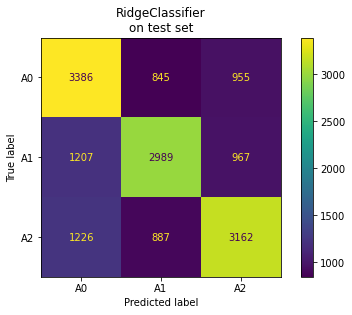

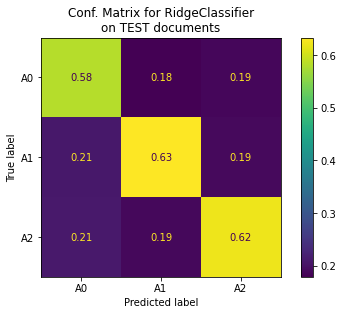


>>> Best Accuracy: (RidgeClassifier) 0.6104 <<<

##########################################################################################
LogisticRegression
##########################################################################################
Tipo de excepción: <class 'KeyboardInterrupt'>
Detalles de la excepción: 
Traceback: <traceback object at 0x000002658290A400>


>>> Best Accuracy: (RidgeClassifier) 0.6104 <<<



TypeError: exceptions must derive from BaseException

In [17]:
from tfg.modelo import all_classifiers, classifiers

classifiers(X_train, y_train, X_test, y_test, classifiers_list, metadata, gen_conf_matrix=True)